# **Assignment 2**

# TASK 1 
1. Fill missing values using generative model (Autoencoder)
2. Measure the perfomence of autoencoder approach perfomence and compare with statistical approaches (i.e From here)
3. Reduce the dimenssion of the data using Principal component analysis and Linear Discriminant Analysis and compare the impact on selected machine learning model

In [241]:
!pip install torch-summary

In [242]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [243]:
identity = pd.read_csv('../input/assignment2data/data_identity.csv', encoding = 'utf-8')
transaction = pd.read_csv('../input/assignment2data/data_transaction.csv', encoding = 'utf-8')


In [244]:
cat_feats_transaction = transaction.select_dtypes(include=['object']).columns.tolist()
cat_feats_identity = identity.select_dtypes(include=['object']).columns.tolist()
transaction = transaction.drop(columns = cat_feats_transaction)
identity = identity.drop(columns = cat_feats_identity)
df = pd.merge(transaction, identity , on = 'TransactionID')
df_label = df['isFraud']
df = df.drop(columns = ['isFraud'])

df.shape


(144233, 402)

In [245]:
identity = None
transaction = None

In [246]:
# from sklearn import preprocessing
# encoder = preprocessing.LabelEncoder()
# for feature in cat_feats_transaction:
#     transaction[feature] = encoder.fit_transform(transaction[feature])
# for feature in cat_feats_identity:
#     identity[feature] = encoder.fit_transform(identity[feature])


# import numpy as np
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
# imputer.fit_transform(df)




# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit_transform(df)



# Simple autoencoder

In [247]:
## SIMPLE AUTOENCODER
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim = 10):
      super(autoencoder, self).__init__()
      self.encoder = nn.Sequential(
          nn.Linear(input_size, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, input_size//4),
          nn.ReLU(),
          nn.Linear(input_size//4, input_size//8),
          nn.ReLU(),
          nn.Linear(input_size//8, latent_dim)
      )
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//8),
          nn.ReLU(),
          nn.Linear(input_size//8, input_size//4),
          nn.ReLU(),
          nn.Linear(input_size//4, input_size//2)
      )
      self.encoder.apply(self.__init_weights)
      self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x
    
    def __init_weights(self,m):
      if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

In [248]:
def train(model, data, batch_size, regularized = False, lr = 1e-6, loss = nn.MSELoss(), train_epochs = 100):
    data = torch.tensor(data)
    n_features = data.shape[1]
    model = model(n_features * 2).to(device)
    indicator = torch.isnan(data)
    data[indicator] = 1
    data_with_indicator = torch.hstack([data, ~indicator])
    X_train, X_test = train_test_split(data_with_indicator, test_size = 0.2, random_state = 42)
    train_data_loader = torch.utils.data.DataLoader(X_train.to(device), batch_size = batch_size,
                                                             shuffle = True)
    print(len(train_data_loader))
    test_data_loader = torch.utils.data.DataLoader(X_test.to(device), batch_size = batch_size,
                                                            shuffle = False)
    
    if regularized:
        criterion = nn.L1Loss()
    else:
        criterion = nn.MSELoss()
 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    history = {'train_loss': [], 'test_loss': []}
    print(model)
    def _train_epoch(model, optimizer, criterion):
        epoch_loss = 0
        model.train()

        for batch in train_data_loader:
            batch_input = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch_input)
            if not regularized:
                input_values = batch_input[:, :n_features]
                missing_indicator = batch_input[:, n_features:]
                loss = criterion(input_values * (1 - missing_indicator), pred * (1 - missing_indicator))
                loss1 = loss
            else:
                input_values = batch_input[:, :n_features]
                missing_indicator = batch_input[:, n_features:]
                observed_indicator = 1 - missing_indicator
                criterion_loss = criterion(input_values * (1 - missing_indicator), pred * (1 - missing_indicator))
                loss = 0
                model_children = list(model.children())
                values = batch_input
                for i in range(len(model_children)):
                    values = F.relu((model_children[i](values)))
                    loss += torch.mean(torch.abs(values))
                loss = 0.5 * loss + criterion_loss
                loss1 = criterion_loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss1.item()

        return epoch_loss / len(train_data_loader)
    
    def test_epoch(model, criterion):
        model.eval()
        with torch.no_grad():
            pred = model(test_data_loader.dataset)
            input_test = test_data_loader.dataset
            input_values = input_test[:, :n_features]
            missing_indicator = input_test[:, n_features:]
            observed_indicator = 1 - missing_indicator
            loss = criterion(input_values * (1 - missing_indicator), pred * (1 - missing_indicator))
        return loss.item()
    
    for epoch in range(train_epochs):
        train_loss = _train_epoch(model, optimizer, criterion)
        test_loss = test_epoch(model, criterion)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        if epoch % 10 == 0:
            print('epoch', epoch, "train_loss:", train_loss, 'test_loss:', test_loss)
    best = np.argmin(history['test_loss'])
    ae_performance = [history['train_loss'][best], history['test_loss'][best]]
    return ae_performance, model




In [249]:


class VAE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size // 4), 
            nn.ReLU(),
            nn.BatchNorm1d(input_size // 4, momentum = 0.7),
            nn.Linear(input_size // 4, input_size // 16), 
            nn.ReLU(),
            nn.BatchNorm1d(input_size // 16, momentum = 0.7),
            nn.Linear(input_size // 16, input_size // 32), 
            nn.LeakyReLU()
        )
        self.hidden2mu = nn.Linear(input_size // 32, input_size // 32)
        self.hidden2log_var = nn.Linear(input_size // 32, input_size // 32)

        
        self.decoder = nn.Sequential(
            nn.Linear(input_size // 32, input_size // 16), 
            nn.ReLU(),
            nn.Linear(input_size // 16, input_size // 8), 
            nn.ReLU(),
            nn.Linear(input_size // 8, int(input_size / 2)), 
            nn.ReLU()
        )

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden2mu(hidden)
        log_var = self.hidden2log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        sigma = torch.exp(log_var/2)
        z = torch.randn(size=(mu.size(0), mu.size(1)))
        z = z.type_as(mu)
        return mu + sigma * z

    def forward(self, x):
        mu, log_var = self.encode(x)
        hidden = self.reparametrize(mu, log_var)
        return self.decoder(hidden)

In [250]:

def train2(model, data, batch_size, lr = 1e-6, loss = nn.MSELoss(), train_epochs = 100):
    data = torch.tensor(data)
    n_features = data.shape[1]
    model = model(n_features * 2).to(device)
    indicator = torch.isnan(data)
    data[indicator] = 1
    data_with_indicator = torch.hstack([data, ~indicator])
    X_train, X_test = train_test_split(data_with_indicator, test_size = 0.2, random_state = 42)
    train_data_loader = torch.utils.data.DataLoader(X_train.to(device), batch_size = batch_size,
                                                             shuffle = True)
    test_data_loader = torch.utils.data.DataLoader(X_test.to(device), batch_size = batch_size,
                                                            shuffle = False)
    criterion = nn.MSELoss()
    
 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    history = {'train_loss': [], 'test_loss': []}
    print(model)
 
    def _train_epoch(model, optimizer, criterion):
        epoch_loss = 0
        model.train()

        for batch in train_data_loader:
            batch_input = batch.to(device)
            optimizer.zero_grad()
            mu, log_var = model.encode(batch_input)
            pred = model(batch_input)
            kl_loss = (-0.5 * (1 + log_var - mu ** 2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
            input_values = batch_input[:, :n_features]
            missing_indicator = batch_input[:, n_features:]
            loss = criterion(input_values * (1 - missing_indicator), pred * (1 - missing_indicator)) + kl_loss
            loss1 = criterion(input_values * (1 - missing_indicator), pred * (1 - missing_indicator))
            loss.backward()
            optimizer.step()
            epoch_loss += loss1.item()

        return epoch_loss / len(train_data_loader)

    def test_epoch( model, criterion):
        model.eval()
        with torch.no_grad():
            pred = model(test_data_loader.dataset)
#             nans = pred.isnan()
#             pred[nans] = 0
            input_test = test_data_loader.dataset
            input_values = input_test[:, :n_features]
            missing_indicator = input_test[:, n_features:]
            loss = criterion(input_values * (1 - missing_indicator), pred * (1 - missing_indicator))
        return loss.item()
    
    for epoch in range(train_epochs):
        train_loss = _train_epoch(model, optimizer, criterion)
        test_loss = test_epoch(model, criterion)
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        if epoch % 10 == 0:
            print('epoch', epoch, "train_loss:", train_loss, 'test_loss:', test_loss)
    best = np.argmin(history['test_loss'])
    ae_performance = [history['train_loss'][best], history['test_loss'][best]]
    return ae_performance, model



In [251]:
x = torch.torch.from_numpy(df.values).to(torch.float32)
model_simple = autoencoder
model_reg = autoencoder
model_vae = VAE

ae, ae_model = train(model_simple, x, batch_size=512, train_epochs = 120 , lr=1e-6)
ae_reg, ae_reg_model = train(model_reg, x, batch_size=512, regularized = True, train_epochs = 100 , lr=1e-6)
vae, vae_model = train2(model_vae, x, batch_size=512, train_epochs = 100 , lr=1e-6)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


226
autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=804, out_features=402, bias=True)
    (1): ReLU()
    (2): Linear(in_features=402, out_features=201, bias=True)
    (3): ReLU()
    (4): Linear(in_features=201, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=201, bias=True)
    (3): ReLU()
    (4): Linear(in_features=201, out_features=402, bias=True)
  )
)
epoch 0 train_loss: 124315000.74336283 test_loss: 90467080.0
epoch 10 train_loss: 591619.6942754425 test_loss: 494031.59375
epoch 20 train_loss: 89310.05548257743 test_loss: 85393.0546875
epoch 30 train_loss: 31682.121465362277 test_loss: 31054.728515625
epoch 40 train_loss: 12148.818398264657 test_loss: 11914.4296875
epoch 50 train_loss: 4867.962590310426 test_loss: 4763.90185546875
epoch 60 train_loss: 194

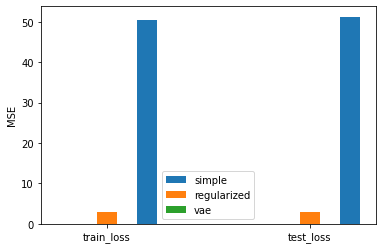

In [252]:
import matplotlib.pyplot as plt
X = ['train_loss','test_loss']
X_axis = np.arange(len(X))
  
plt.bar(X_axis + 0.2, ae, 0.1, label = 'simple')
plt.bar(X_axis, ae_reg, 0.1, label = 'regularized')
plt.bar(X_axis - 0.2, vae, 0.1, label = 'vae')


plt.xticks(X_axis, X)
plt.ylabel("MSE")
plt.legend()
plt.show()

In [255]:
x = torch.torch.from_numpy(df.values).to(torch.float32)
data = torch.tensor(x)
indicator = torch.isnan(data)
data[indicator] = 1
data_with_indicator = torch.hstack([data, ~indicator])
data_loader = torch.utils.data.DataLoader(data_with_indicator.to(device), batch_size = 128,
                                                             shuffle = False)
ae_model.eval()
with torch.no_grad():
    pred = ae_model(data_loader.dataset)
    nans = pred.isnan()
    pred[nans] = 0

pred.shape
X1 = pred.cpu().numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [257]:
X1.shape

(144233, 402)

In [258]:
x = torch.torch.from_numpy(df.values).to(torch.float32)
data = torch.tensor(x)
indicator = torch.isnan(data)
data[indicator] = 1
data_with_indicator = torch.hstack([data, ~indicator])
data_loader = torch.utils.data.DataLoader(data_with_indicator.to(device), batch_size = 128,
                                                             shuffle = False)
ae_reg_model.eval()
with torch.no_grad():
    pred = ae_reg_model(data_loader.dataset)
    nans = pred.isnan()
    pred[nans] = 0

pred.shape
X2 = pred.cpu().numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [259]:
x = torch.torch.from_numpy(df.values).to(torch.float32)
data = torch.tensor(x)
indicator = torch.isnan(data)
data[indicator] = 1
data_with_indicator = torch.hstack([data, ~indicator])
data_loader = torch.utils.data.DataLoader(data_with_indicator.to(device), batch_size = 128,
                                                             shuffle = False)
vae_model.eval()
with torch.no_grad():
    pred = vae_model(data_loader.dataset)
    nans = pred.isnan()
    pred[nans] = 0

pred.shape
X3 = pred.cpu().numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [260]:
y = df_label
y.shape

(144233,)

In [261]:
X1.shape

(144233, 402)

In [262]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier()


X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y, test_size = 0.2, random_state = 0)


clf.fit(X1_train, y_train)
print(classification_report(clf.predict(X1_test), y_test, digits = 6))

              precision    recall  f1-score   support

           0   0.998497  0.922511  0.959001     28804
           1   0.001342  0.069767  0.002634        43

    accuracy                       0.921240     28847
   macro avg   0.499920  0.496139  0.480817     28847
weighted avg   0.997011  0.921240  0.957575     28847



In [263]:
X2_train, X2_test, y_train, y_test = train_test_split(
    X2, y, test_size = 0.2, random_state = 0)

clf.fit(X2_train, y_train)
print (classification_report(clf.predict(X2_test),y_test, digits = 6))

              precision    recall  f1-score   support

           0   0.999399  0.922543  0.959434     28829
           1   0.000895  0.111111  0.001775        18

    accuracy                       0.922037     28847
   macro avg   0.500147  0.516827  0.480605     28847
weighted avg   0.998776  0.922037  0.958837     28847



In [264]:
import numpy as np
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
imputer.fit(df)
imputed_df = imputer.transform(df)
X_imp_train, X_imp_test, y_train, y_test = train_test_split(
    X2, y, test_size = 0.2, random_state = 0)

clf.fit(X_imp_train, y_train)
print (classification_report(clf.predict(X_imp_test),y_test, digits = 6))

              precision    recall  f1-score   support

           0   0.999248  0.922629  0.959411     28822
           1   0.002237  0.200000  0.004425        25

    accuracy                       0.922002     28847
   macro avg   0.500743  0.561314  0.481918     28847
weighted avg   0.998384  0.922002  0.958584     28847



In [265]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components=100)
pca.fit(X1)

PCA(n_components=100)

[0.1184122  0.08757355 0.08256502 0.06303466 0.05807174 0.05182737
 0.04589581 0.04023639 0.03050746 0.02683931 0.02487024 0.02241323
 0.01671828 0.01539632 0.01459655 0.01407999 0.01286237 0.01264027
 0.01179736 0.01060628 0.01039183 0.00934061 0.0089244  0.00803285
 0.0078277  0.00762898 0.00713456 0.0067908  0.00650651 0.00641141
 0.00633827 0.00567782 0.00560482 0.00529556 0.00508268 0.00497943
 0.00480223 0.00451047 0.00435448 0.00416691 0.00391009 0.0036076
 0.00352139 0.00327398 0.00324889 0.00309274 0.00300788 0.00287607
 0.00275487 0.00256176 0.00245409 0.00238109 0.00227462 0.00226559
 0.00214736 0.00209371 0.00207893 0.00201299 0.00192668 0.00184083
 0.00182288 0.00174037 0.00166379 0.00160908 0.00153532 0.00152663
 0.00143469 0.00141353 0.0013364  0.00131884 0.00127766 0.00123716
 0.0011632  0.00114312 0.00110027 0.0010893  0.00100596 0.00100408
 0.00097331 0.00095753 0.00091114 0.00090206 0.00085735 0.00084591
 0.00083448 0.00081035 0.00077101 0.00074813 0.00073437 0.00071

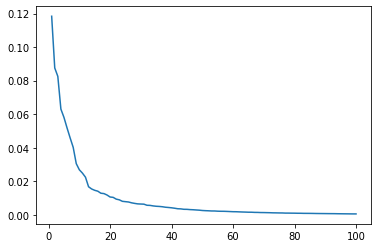

In [266]:
print(pca.explained_variance_ratio_)
plt.plot(range(1, 101), pca.explained_variance_ratio_)

In [267]:
X1_reduced = pca.transform(X1)
X1_train, X1_test, y_train, y_test = train_test_split(
    X1_reduced, y, test_size = 0.2, random_state = 0)
clf.fit(X1_train, y_train)
print(classification_report(clf.predict(X1_test), y_test, digits = 6))
# accuracy decreased

              precision    recall  f1-score   support

           0   0.924808  0.922140  0.923472     26689
           1   0.070246  0.072753  0.071477      2158

    accuracy                       0.858599     28847
   macro avg   0.497527  0.497446  0.497475     28847
weighted avg   0.860880  0.858599  0.859736     28847



In [268]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X1_train, X1_test, y_train, y_test = train_test_split(
    X1_reduced, y, test_size = 0.2, random_state = 0)
lda.fit(X1_train, y_train)
print(classification_report( lda.predict(X1_test), y_test, digits = 6))


              precision    recall  f1-score   support

           0   0.999136  0.922653  0.959372     28818
           1   0.002685  0.206897  0.005300        29

    accuracy                       0.921933     28847
   macro avg   0.500910  0.564775  0.482336     28847
weighted avg   0.998134  0.921933  0.958413     28847



# TASK 2

In [202]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [203]:
# Here I am reading the train and test data
train = pd.read_csv('../input/task2data/UNSW_NB15_testing-set.csv')
test = pd.read_csv('../input/task2data/UNSW_NB15_training-set.csv')
df = pd.concat([train, test])
cat_feats = df.select_dtypes(['object']).columns

In [204]:
# Here I am encoding the categorical features
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for feature in cat_feats:
    df[feature] = le.fit_transform(df[feature])

In [205]:
# Here I am finding the columns which have almost same values
same_val_columns = []
for col in df.columns:
    val, counts = np.unique(df[col],return_counts=True)
    v = counts[0] / counts.sum()
    if v > 0.95:
        same_val_columns.append(col)

same_val_columns



['is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports']

In [206]:
# Here I am splitting the data
x_train = df.iloc[:len(train)]
x_test = df.iloc[len(train):]

In [207]:
# Here I am removing the columns which have almost all same values
x_train.drop(same_val_columns, inplace = True, axis = 1)
x_test.drop(same_val_columns, inplace = True, axis = 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [208]:
# Here I am extracting the labels
y_train = x_train["attack_cat"]
y_test = x_test["attack_cat"]

x_train.drop("attack_cat", inplace = True, axis = 1)
x_test.drop("attack_cat", inplace = True, axis = 1)

In [209]:
# Here I am converting to numpy and scaling using a standard scale
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.to_numpy())
x_test = scaler.transform(x_test.to_numpy())
y_train = y_train.to_numpy(dtype=int)
y_test = y_test.to_numpy(dtype=int)

In [210]:
# Here I am converting into torch
x_train, x_test, y_train, y_test = torch.Tensor(x_train), torch.Tensor(x_test),torch.tensor(y_train, dtype=torch.int64), torch.tensor(y_test, dtype=torch.int64)


In [211]:
# Here I am creating data loaders
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size = 64, shuffle = True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size = 64, shuffle = True)

In [212]:
# Here I am creating Generator and Discriminator classes
class Generator(nn.Module):
    def __init__(self,output_dim, noise_dim=32):
        super(Generator, self).__init__()
        input_out_feats = 64
        emb_dim = 23
        self.input_layer = nn.Linear(in_features = noise_dim, out_features = input_out_feats)
        self.emb_y = nn.Sequential(
            nn.Embedding(num_embeddings = 10,embedding_dim = emb_dim), 
            nn.Flatten()
        )
        self.model = nn.Sequential( 
            nn.Linear(input_out_feats + emb_dim, 128), 
            nn.ReLU(),                      
            nn.Linear(128, 256), 
            nn.ReLU(),                   
            nn.Linear(256, 512), 
            nn.ReLU(),              
            nn.Linear(512, output_dim), 
            nn.Tanh()
        )
        
    def forward(self, x, y):
         x = self.input_layer(x)
         y = self.emb_y(y)
         return self.model(torch.cat((x, y), dim = 1))
        
        
class Discriminator(nn.Module):
    def __init__(self,input_size):
        super(Discriminator, self).__init__()
        emb_dim = 23
        self.emb_y = nn.Sequential(
            nn.Embedding(num_embeddings = 10,embedding_dim = emb_dim),
            nn.Flatten()
        )
        self.model = nn.Sequential(nn.Linear(input_size + emb_dim, 512), 
                                   nn.LeakyReLU(),
                                   nn.Linear(512, 256), 
                                   nn.LeakyReLU(),
                                   nn.Linear(256, 128), 
                                   nn.LeakyReLU(),
                                   nn.Linear(128, 1), 
                                   nn.Sigmoid()
                                  )

    def forward(self, x, y):
        y = self.emb_y(y)
        return self.model(torch.cat((x, y),dim = 1))

In [213]:
# Here I am assigning gen and dis objects and optimizers
D = Discriminator(input_size = 41).to(device).float()
G = Generator(output_dim = 41, noise_dim = 32).to(device).float()
loss_module = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), learning_rate)
g_optimizer = optim.SGD(G.parameters(), learning_rate)

In [214]:
# Here I am creating loss functions
def real_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.FloatTensor(batch_size).uniform_(0.9, 1).to(device)
    loss_fn = nn.BCELoss()
    loss = loss_fn(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.FloatTensor(batch_size).uniform_(0, 0.1).to(device)
    loss_fn = nn.BCELoss()
    loss = loss_fn(D_out.squeeze(), labels)
    return loss

In [181]:
# Here I am training the GAN
num_epochs = 500
z_size = 32

losses = []

for epoch in range(num_epochs):

    for batch_index, (X, y) in enumerate(train_loader):

        batch_size = X.size(0)
        z = np.random.uniform(0, 1, size = (batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        
        d_optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
        
        d_real = D(X, y)
        d_loss = real_loss(d_real)
        
        g_fake = G(z, y)
        d_fake = D(g_fake, y)
        
        d_loss = d_loss + fake_loss(d_fake)
        d_loss.backward()
        
        d_optimizer.step()
        g_optimizer.zero_grad()
        
        g_fake = G(z, y)
        g_loss = real_loss(D(g_fake, y))
        
        g_loss.backward()
        g_optimizer.step()
            
    print('epoch [{}/{}], d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch + 1, num_epochs, d_loss.item(), g_loss.item()))
    losses.append((d_loss.item(), g_loss.item()))
    

epoch [1/500], d_loss: 1.2877 | g_loss: 0.6900
epoch [2/500], d_loss: 1.0902 | g_loss: 0.7575
epoch [3/500], d_loss: 0.7080 | g_loss: 1.1441
epoch [4/500], d_loss: 0.7518 | g_loss: 1.4317
epoch [5/500], d_loss: 0.6209 | g_loss: 1.9570
epoch [6/500], d_loss: 0.6218 | g_loss: 2.1678
epoch [7/500], d_loss: 0.5249 | g_loss: 1.9348
epoch [8/500], d_loss: 0.4421 | g_loss: 2.2809
epoch [9/500], d_loss: 0.4895 | g_loss: 2.1976
epoch [10/500], d_loss: 0.4252 | g_loss: 2.6557
epoch [11/500], d_loss: 0.4205 | g_loss: 2.7285
epoch [12/500], d_loss: 0.4848 | g_loss: 2.7081
epoch [13/500], d_loss: 0.4083 | g_loss: 2.7500
epoch [14/500], d_loss: 0.4131 | g_loss: 2.7608
epoch [15/500], d_loss: 0.4308 | g_loss: 2.1809
epoch [16/500], d_loss: 0.4103 | g_loss: 2.6690
epoch [17/500], d_loss: 0.4625 | g_loss: 2.4345
epoch [18/500], d_loss: 1.0832 | g_loss: 1.2225
epoch [19/500], d_loss: 0.7717 | g_loss: 1.5227
epoch [20/500], d_loss: 0.7676 | g_loss: 1.5767
epoch [21/500], d_loss: 0.6686 | g_loss: 1.7055
e

In [231]:
# Here I am generating new data
G.eval()
unique_labels = np.unique(y_train)
dict_len = {}
max_len = 0

for label in unique_labels:
    dict_len[label] = len(np.where(y_train == label)[0])
    if max_len < dict_len[label]:
        max_len = dict_len[label]
        
new_data = {}

for label in unique_labels:
    if max_len > dict_len[label]:
        size = max_len - dict_len[label]
        y = torch.ones((size), dtype = torch.int64).to(device) * label
        z = np.random.uniform(-1, 1, size = (size, z_size))
        z = torch.from_numpy(z).float().to(device)
        new_data[label] = G(z, y).cpu().detach().numpy()

In [232]:
# Here is newly generated data
new_data

{0: array([[ 0.82648975,  0.6938739 , -0.16330588, ..., -0.80351794,
         -0.730387  ,  0.95089126],
        [ 0.82003474,  0.70670223, -0.11075535, ..., -0.7480745 ,
         -0.7210134 ,  0.93861014],
        [ 0.6846276 ,  0.5665753 , -0.05828349, ..., -0.68005884,
         -0.6099124 ,  0.8518565 ],
        ...,
        [ 0.8363304 ,  0.730654  , -0.16781649, ..., -0.78669643,
         -0.7281877 ,  0.95153016],
        [ 0.5514046 ,  0.44331607, -0.02253831, ..., -0.62286586,
         -0.53327906,  0.7581653 ],
        [ 0.50857645,  0.4207632 , -0.0356461 , ..., -0.6079501 ,
         -0.5270349 ,  0.7426068 ]], dtype=float32),
 1: array([[ 0.04596491,  0.44414625, -0.17368749, ..., -0.73869634,
         -0.08327262,  0.22489479],
        [ 0.19919805,  0.4912507 , -0.12367153, ..., -0.68481183,
         -0.22036065,  0.37008792],
        [ 0.01410807,  0.41560337, -0.11950813, ..., -0.674502  ,
         -0.08875272,  0.12634438],
        ...,
        [ 0.11690559,  0.4430459 

In [233]:
# Here I am creating the new train test data using the previous and generated data
labels = []
inputs = []

for key, value in new_data.items():
    size = len(value)
    labels.append(np.ones(size) * key)
    inputs.append(value)
        
    labels.append(y_train.numpy())
    inputs.append(x_train.numpy())

    new_x = np.concatenate(inputs)
    new_y = np.concatenate(labels)

    s_index = np.random.permutation(len(new_x))
    
    new_x = new_x[s_index]
    new_y = new_y[s_index]
    
    new_x_train = torch.tensor(new_x)
    new_y_train = torch.tensor(new_y, dtype=torch.int64)

In [234]:
# Here is the new data
new_x

array([[-1.4219648 , -0.20961441,  0.4202353 , ..., -0.11485821,
        -0.753074  , -1.459825  ],
       [ 0.10424016,  0.5557494 , -0.09838868, ..., -0.6291045 ,
        -0.16270211,  0.19772401],
       [ 0.11788639,  0.5436281 , -0.08746612, ..., -0.61640584,
        -0.16525245,  0.23543686],
       ...,
       [ 1.5349711 , -0.20977429,  0.4202353 , ...,  1.2070237 ,
         0.7343404 ,  0.6850136 ],
       [ 0.08633551,  0.1724255 ,  0.01022314, ..., -0.45862252,
        -0.24492627,  0.21430612],
       [-0.05731323, -0.16397668,  0.1518094 , ..., -0.35520038,
         0.2695234 , -1.459825  ]], dtype=float32)

In [235]:
# Here I am testing the Random Forest with the initial data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(x_train.numpy(), y_train.numpy())
print(classification_report(y_test, clf.predict(x_test)))


              precision    recall  f1-score   support

           0       0.00      0.01      0.01       677
           1       0.02      0.09      0.03       583
           2       0.24      0.12      0.16      4089
           3       0.80      0.59      0.68     11132
           4       0.81      0.67      0.73      6062
           5       1.00      0.96      0.98     18871
           6       0.90      1.00      0.95     37000
           7       0.96      0.74      0.84      3496
           8       0.34      0.41      0.37       378
           9       0.62      0.11      0.19        44

    accuracy                           0.84     82332
   macro avg       0.57      0.47      0.49     82332
weighted avg       0.85      0.84      0.84     82332



In [236]:
# Here I am testing the RF with the newly generated data
clf.fit(new_x, new_y)
print(classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.02      0.03      0.03       677
           1       0.02      0.08      0.03       583
           2       0.24      0.10      0.14      4089
           3       0.82      0.50      0.62     11132
           4       0.71      0.56      0.63      6062
           5       1.00      0.96      0.98     18871
           6       0.84      1.00      0.91     37000
           7       0.96      0.62      0.76      3496
           8       0.28      0.30      0.29       378
           9       0.57      0.09      0.16        44

    accuracy                           0.81     82332
   macro avg       0.55      0.43      0.45     82332
weighted avg       0.82      0.81      0.81     82332



In [239]:
!pip install interpret

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
clf = ExplainableBoostingClassifier(max_bins=3, n_jobs=-1, interactions=0, max_leaves=25)
clf.fit(x_train.numpy(),y_train.numpy())
print(classification_report(y_test, clf.predict(x_test)))

In [ ]:
clf.fit(new_x, new_y)
print(classification_report(y_test, clf.predict(x_test)))

In [ ]:
class nnet(nn.Module):
    
  def __init__(self):
    super(nnet, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(41, 30),
      nn.ReLU(True),
      nn.Linear(30, 10)
    )
    self.model.apply(self.__init_weights)

  def forward(self, x):
    return self.model(x)
  
  def __init_weights(self,m):
    if type(m) == nn.Linear:
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

In [ ]:
model = nnet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

model.train()

for epoch in range(10):
    for X, y in new_x, new_y:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
model.eval()

y_pred = torch.max(model(x_test.to(device)).data, 1)[1].cpu().detach().numpy()
print(classification_report(y_pred, y_test.numpy()))